# prep airbnb listings data


### imports


In [6]:
from typing import Any
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import re

### load data


In [7]:
data = pd.read_csv("../local_data/relevant_listings.csv")

### select required cols


In [8]:
required_cols = [
    "name",
    "latitude",
    "longitude",
    "price",
]
drop_cols = []
listings = data.drop(columns=drop_cols, errors="ignore").copy()
listings = listings.dropna(subset=required_cols)

## process data


In [9]:
def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert cols to appropriate data types.
    """
    # Make a copy to avoid modifying original
    df = df.copy()

    # Convert date cols to datetime
    date_cols = ["last_scraped", "host_since", "first_review", "last_review"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])

    # Convert boolean cols
    bool_cols = [
        "host_is_superhost",
        "host_has_profile_pic",
        "host_identity_verified",
        "has_availability",
        "instant_bookable",
    ]
    for col in bool_cols:
        df[col] = df[col].replace({"t": True, "f": False})

    # Convert price to numeric
    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
    df["host_response_rate"] = (
        df["host_response_rate"].str.replace("%", "").str.replace(",", "").astype(float)
    )
    df["host_acceptance_rate"] = (
        df["host_acceptance_rate"]
        .str.replace("%", "")
        .str.replace(",", "")
        .astype(float)
    )

    # Convert amenities from string to list
    df["amenities"] = df["amenities"].apply(
        eval
    )  # Convert string representation to list

    return df


def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time-based features.
    """
    current_date = pd.Timestamp.now()

    # Host experience duration (days)
    df["host_experience_days"] = (current_date - df["host_since"]).dt.days

    # Listing age (days)
    df["listing_age_days"] = (current_date - df["first_review"]).dt.days

    # Days since last review
    df["days_since_last_review"] = (current_date - df["last_review"]).dt.days

    return df


def create_location_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create location-based features.
    """
    # Zurich city center coordinates (approximate)
    ZURICH_CENTER = (47.3769, 8.5417)

    # Calculate distance to city center using Haversine formula
    def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        R = 6371  # Earth's radius in km

        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    df["distance_to_center_km"] = df.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], ZURICH_CENTER[0], ZURICH_CENTER[1]
        ),
        axis=1,
    )

    return df


def create_price_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create price-related features.
    """
    # Price per person
    df["price_per_person"] = df["price"] / df["accommodates"]

    return df


def create_amenity_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create amenity-based features.
    """
    # Amenity count
    df["amenity_count"] = df["amenities"].str.len()

    # Get top amenities
    all_amenities = [item for sublist in df["amenities"] for item in sublist]
    top_amenities = pd.Series(all_amenities).value_counts().head(20).index

    # Create binary cols for top amenities
    for amenity in top_amenities:
        df[f'has_{amenity.lower().replace(" ", "_")}'] = df["amenities"].apply(
            lambda x: amenity in x if isinstance(x, list) else False
        )

    return df


def create_categorical_dummies(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create dummy variables for categorical columns.

    Args:
        df: DataFrame containing Airbnb listings

    Returns:
        DataFrame with added dummy columns
    """
    # Make a copy to avoid modifying original
    df = df.copy()

    # Columns to create dummies for
    categorical_cols = [
        "neighbourhood_group_cleansed",
        "neighbourhood_cleansed",
        "room_type",
    ]

    # Create dummies for each column
    for col in categorical_cols:
        if col in df.columns:
            # Create dummy columns with prefix
            dummy_cols = pd.get_dummies(df[col], prefix=f"{col}_", dtype=int)

            # Add dummy columns to dataframe
            df = pd.concat([df, dummy_cols], axis=1)

            # Drop original column
            df = df.drop(columns=[col])

    return df


def create_bathroom_features(df: pd.DataFrame) -> pd.DataFrame:
    df["bathrooms"] = df["bathrooms_text"].str.extract("(\d+\.?\d*)").astype(float)
    df.loc[
        df["bathrooms_text"].str.contains("half", flags=re.IGNORECASE, na=False)
        == True,
        "bathrooms",
    ] = 0.5
    df.rename(columns={"bathrooms_text": "bathrooms_shared"}, inplace=True)
    df["bathrooms_shared"] = np.where(
        df["bathrooms_shared"].str.contains("shared"), True, False
    )

    return df


def process_listings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process listings dataframe and create all features.
    """
    print("Converting data types...")
    df = convert_data_types(df)

    print("Creating time features...")
    df = create_time_features(df)

    print("Creating location features...")
    df = create_location_features(df)

    print("Creating price features...")
    df = create_price_features(df)

    print("Creating amenity features...")
    df = create_amenity_features(df)

    print("Creating bathroom features...")
    df = create_bathroom_features(df)

    print("Creating categorical dummies...")
    df = create_categorical_dummies(df)

    return df

### apply processing


In [10]:
listings_processed = process_listings(listings)

# Display new features
new_features = set(listings_processed.columns) - set(listings.columns)
print("\nnew features:")
for feature in sorted(new_features):
    print(f"- {feature}")

Converting data types...
Creating time features...
Creating location features...
Creating price features...
Creating amenity features...


/var/folders/yj/d6dnn2c12fx2z9d89ztngqn00000gn/T/ipykernel_66635/378933368.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"t": True, "f": False})


Creating bathroom features...
Creating categorical dummies...

new features:
- amenity_count
- bathrooms_shared
- days_since_last_review
- distance_to_center_km
- has_bed_linens
- has_cooking_basics
- has_dedicated_workspace
- has_dishes_and_silverware
- has_dishwasher
- has_essentials
- has_hair_dryer
- has_hangers
- has_heating
- has_hot_water
- has_hot_water_kettle
- has_iron
- has_kitchen
- has_long_term_stays_allowed
- has_oven
- has_refrigerator
- has_self_check-in
- has_shampoo
- has_washer
- has_wifi
- host_experience_days
- listing_age_days
- neighbourhood_cleansed__Affoltern
- neighbourhood_cleansed__Albisrieden
- neighbourhood_cleansed__Alt-Wiedikon
- neighbourhood_cleansed__Altstetten
- neighbourhood_cleansed__City
- neighbourhood_cleansed__Enge
- neighbourhood_cleansed__Escher Wyss
- neighbourhood_cleansed__Fluntern
- neighbourhood_cleansed__Friesenberg
- neighbourhood_cleansed__Gewerbeschule
- neighbourhood_cleansed__Hard
- neighbourhood_cleansed__Hirslanden
- neighbourho

## listings overview


In [11]:
def analyse_numerical_features(df: pd.DataFrame) -> None:
    """
    analyse numerical features with distributions using multiple 3x3 subplots.

    Args:
        df: DataFrame containing Airbnb listings
    """
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    plots_per_figure = 9
    n_figures = (len(numerical_cols) + plots_per_figure - 1) // plots_per_figure

    for fig_num in range(n_figures):
        start_idx = fig_num * plots_per_figure
        end_idx = min(start_idx + plots_per_figure, len(numerical_cols))
        current_cols = numerical_cols[start_idx:end_idx]

        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(
            f"Distribution of Numerical Features (Set {fig_num + 1})",
            fontsize=8,
            y=1.02,
        )

        axes_flat = axes.flatten()

        for i, col in enumerate(current_cols):
            ax = axes_flat[i]

            # Get non-null data and sample if necessary
            non_null_data = df[col].dropna()

            if len(non_null_data) == 0:
                ax.text(
                    0.5, 0.5, f"No data available\nfor {col}", ha="center", va="center"
                )
                ax.set_title(f"{col} Distribution")
                continue

            # Create distribution plot with limited bins
            sns.histplot(data=non_null_data, kde=True, ax=ax, bins=30)

            ax.set_title(f"{col} Distribution")
            ax.tick_params(axis="x", rotation=45)

            try:
                mean_val = non_null_data.mean()
                median_val = non_null_data.median()

                if pd.notnull(mean_val) and pd.notnull(median_val):
                    ax.axvline(
                        mean_val,
                        color="red",
                        linestyle="--",
                        alpha=0.5,
                        label=f"Mean: {mean_val:.2f}",
                    )
                    ax.axvline(
                        median_val,
                        color="green",
                        linestyle="--",
                        alpha=0.5,
                        label=f"Median: {median_val:.2f}",
                    )
                    ax.legend(fontsize="small")
            except Exception as e:
                print(f"Warning: Could not calculate statistics for {col}: {e!s}")

        for j in range(len(current_cols), 9):
            fig.delaxes(axes_flat[j])

        plt.tight_layout()
        plt.show()

    # Correlation matrix
    correlation_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1
    )
    plt.title("Correlation Matrix of Numerical Features")
    plt.tight_layout()
    plt.show()

    # # Price distribution by neighbourhood (top 10)
    # plt.figure(figsize=(12, 6))
    # sns.boxplot(
    #     data=df,
    #     x="neighbourhood_cleansed",
    #     y="price",
    #     order=df.groupby("neighbourhood_cleansed")["price"].median().nlargest(10).index,
    # )
    # plt.xticks(rotation=45)
    # plt.title("Price Distribution by Top 10 Neighbourhoods")
    # plt.tight_layout()
    # plt.show()


def analyse_categorical_features(df: pd.DataFrame) -> None:
    """
    analyse categorical features with visualizations.

    Args:
        df: DataFrame containing Airbnb listings
    """
    categorical_cols = df.select_dtypes(include=["object"]).columns

    # # Room type distribution
    # plt.figure(figsize=(10, 6))
    # sns.countplot(data=df, x="room_type")
    # plt.title("Room Type Distribution")
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    # # Average price by room type
    # plt.figure(figsize=(10, 6))
    # df.groupby("room_type")["price"].mean().plot(kind="bar")
    # plt.title("Average Price by Room Type")
    # plt.ylabel("Average Price ($)")
    # plt.tight_layout()
    # plt.show()

    # Amenities analysis (top 20)
    amenities_list = df["amenities"]
    all_amenities = [item for sublist in amenities_list for item in sublist]
    amenities_freq = pd.Series(all_amenities).value_counts()

    plt.figure(figsize=(12, 6))
    amenities_freq.head(20).plot(kind="bar")
    plt.title("Top 20 Most Common Amenities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def detect_outliers(df: pd.DataFrame) -> dict[str, Any]:
    """
    Detect outliers in numerical cols using multiple methods.

    Args:
        df: DataFrame containing Airbnb listings

    Returns:
        Dictionary containing outlier information
    """
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    outlier_info = {}

    for col in numerical_cols:
        # Skip cols with all missing vals
        if df[col].isna().all():
            continue

        # IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3.0 * IQR
        upper_bound = Q3 + 3.0 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        # Z-score method
        non_null_data = df[col].dropna()
        if len(non_null_data) > 0:  # Only calculate if we have non-null vals
            z_scores = np.abs(stats.zscore(non_null_data))
            z_score_mask = z_scores > 3
            z_score_outliers = non_null_data[z_score_mask]
        else:
            z_score_outliers = pd.Series([])

        outlier_info[col] = {
            "iqr_outliers_count": len(iqr_outliers),
            "z_score_outliers_count": len(z_score_outliers),
            "iqr_bounds": (lower_bound, upper_bound),
        }

    return outlier_info


def analyse_geographical_distribution(df: pd.DataFrame) -> None:
    """
    analyse geographical distribution of listings.

    Args:
        df: DataFrame containing Airbnb listings
    """
    plt.figure(figsize=(12, 8))
    plt.scatter(
        df["longitude"],
        df["latitude"],
        c=df["price"],
        cmap="viridis",
        alpha=0.6,
        vmin=0,
        vmax=df["price"].quantile(0.99),
    )
    plt.colorbar(label="Price ($)")
    plt.title("Geographical Distribution of Listings by Price")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()


def analyse_data_quality(
    df: pd.DataFrame, outlier_info: dict[str, Any]
) -> dict[str, list[str]]:
    """
    Suggest data cleaning steps based on comprehensive analysis.

    Args:
        df: DataFrame containing Airbnb listings
        outlier_info: Dictionary containing outlier information

    Returns:
        Dictionary of cleaning data_quality organized by category
    """
    data_quality = {"1. missing vals": [], "2. Outliers": []}

    # 1. missing vals Analysis
    missing_percentages = df.isnull().mean() * 100
    high_missing = df.columns[missing_percentages > 50].tolist()
    moderate_missing = df.columns[
        (missing_percentages > 20) & (missing_percentages <= 50)
    ].tolist()
    low_missing = df.columns[
        (missing_percentages > 0) & (missing_percentages <= 20)
    ].tolist()

    if high_missing:
        data_quality["1. missing vals"].append(
            f"cols with >50% missing vals:\n   {', '.join(high_missing)}"
        )
    if moderate_missing:
        data_quality["1. missing vals"].append(
            f"cols with 20-50% missing vals:\n   {', '.join(moderate_missing)}"
        )
    if low_missing:
        data_quality["1. missing vals"].append(
            f"cols with <20% missing vals:\n   {', '.join(low_missing)}"
        )

    # 2. Outliers Analysis
    for col, info in outlier_info.items():
        if info["iqr_outliers_count"] > 0:
            data_quality["2. Outliers"].append(
                f"{col}: {info['iqr_outliers_count']} outliers (3x IQR method)"
            )

    return data_quality

### run listings overview


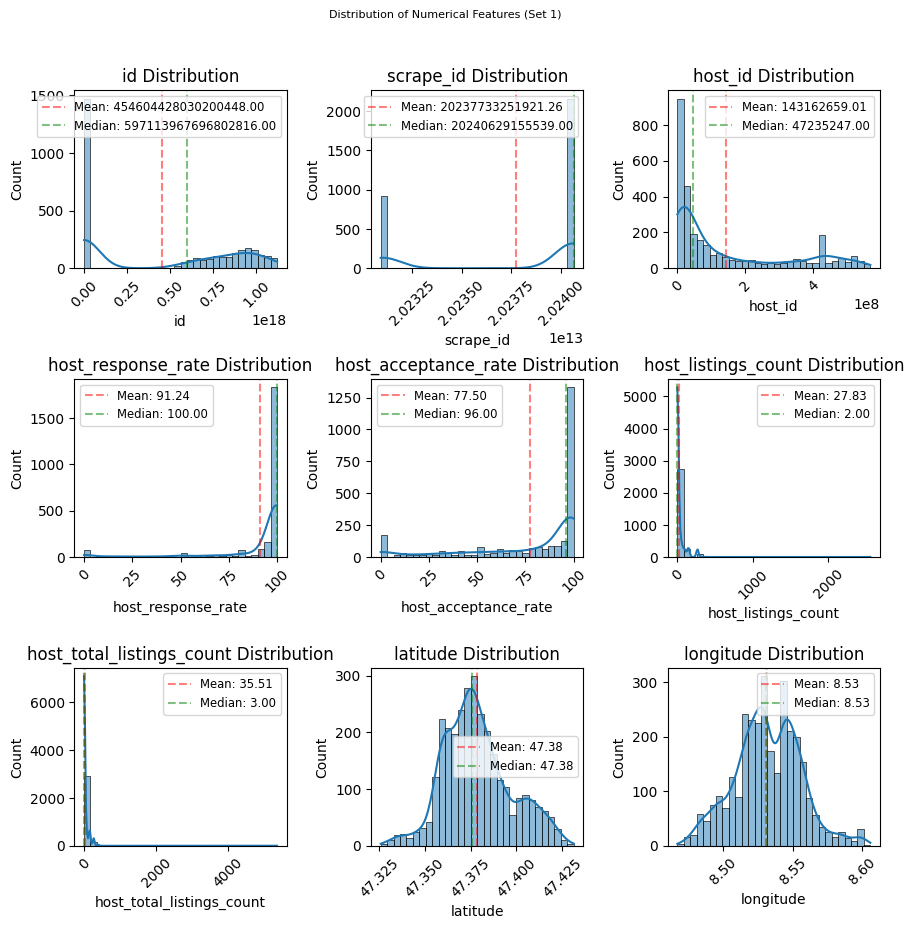

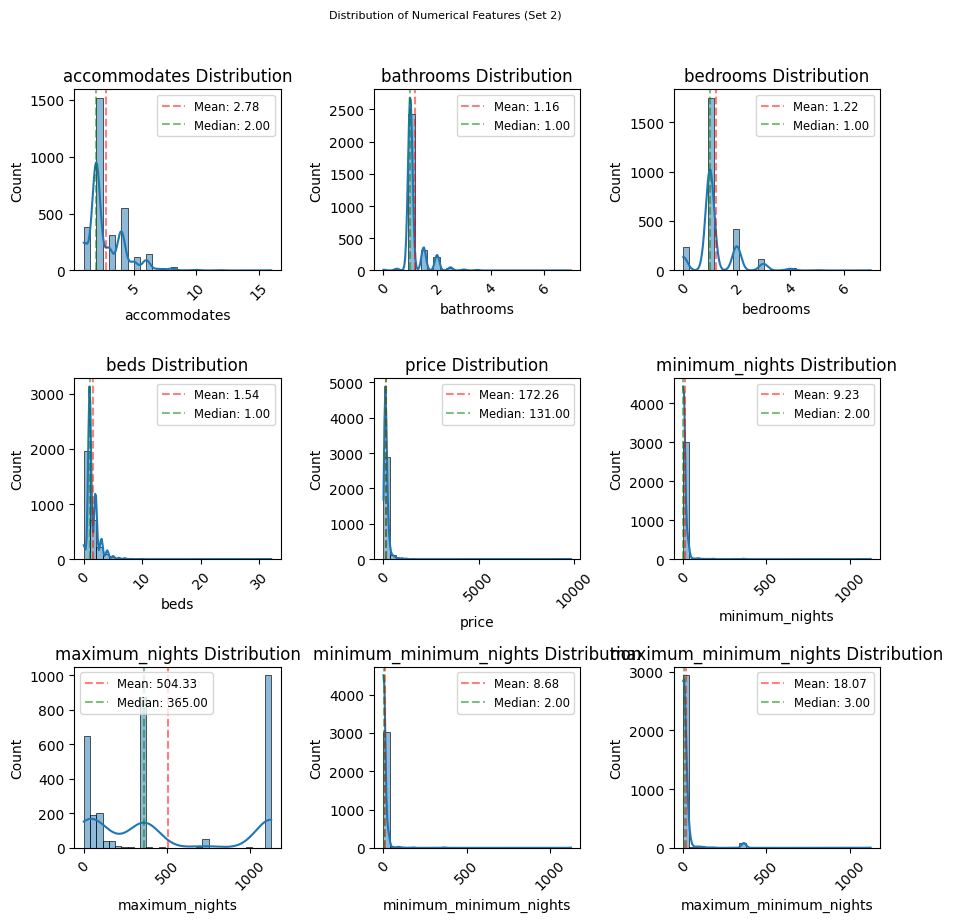

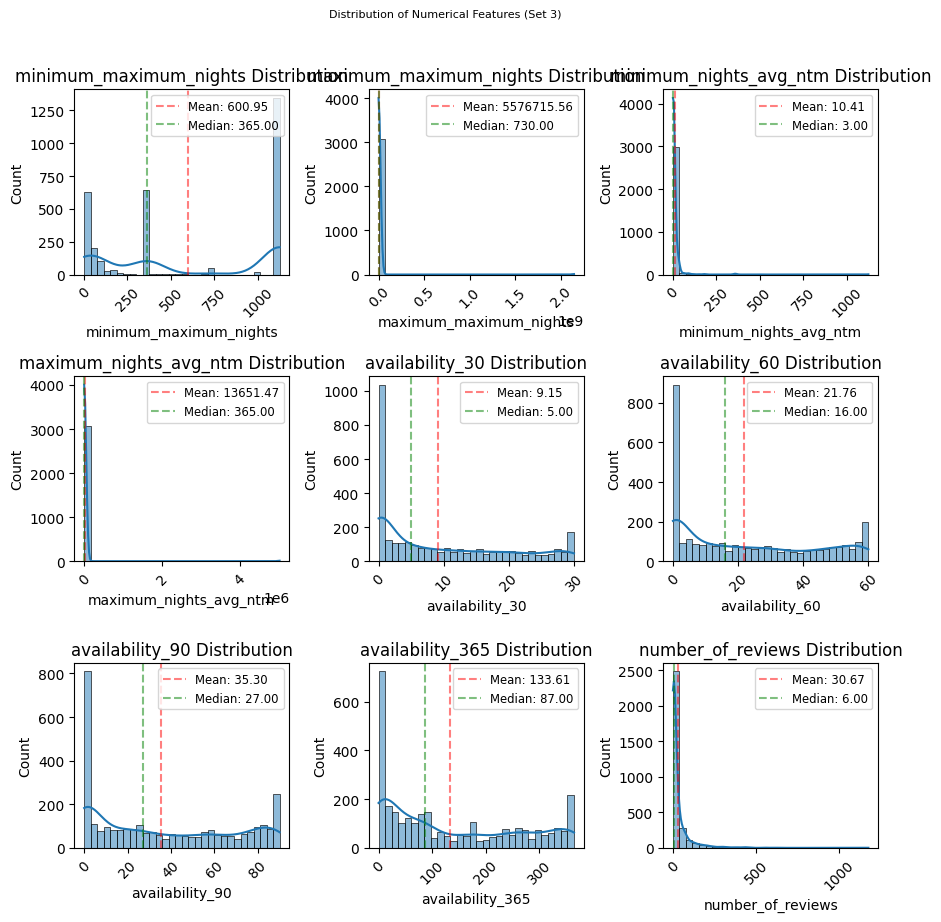

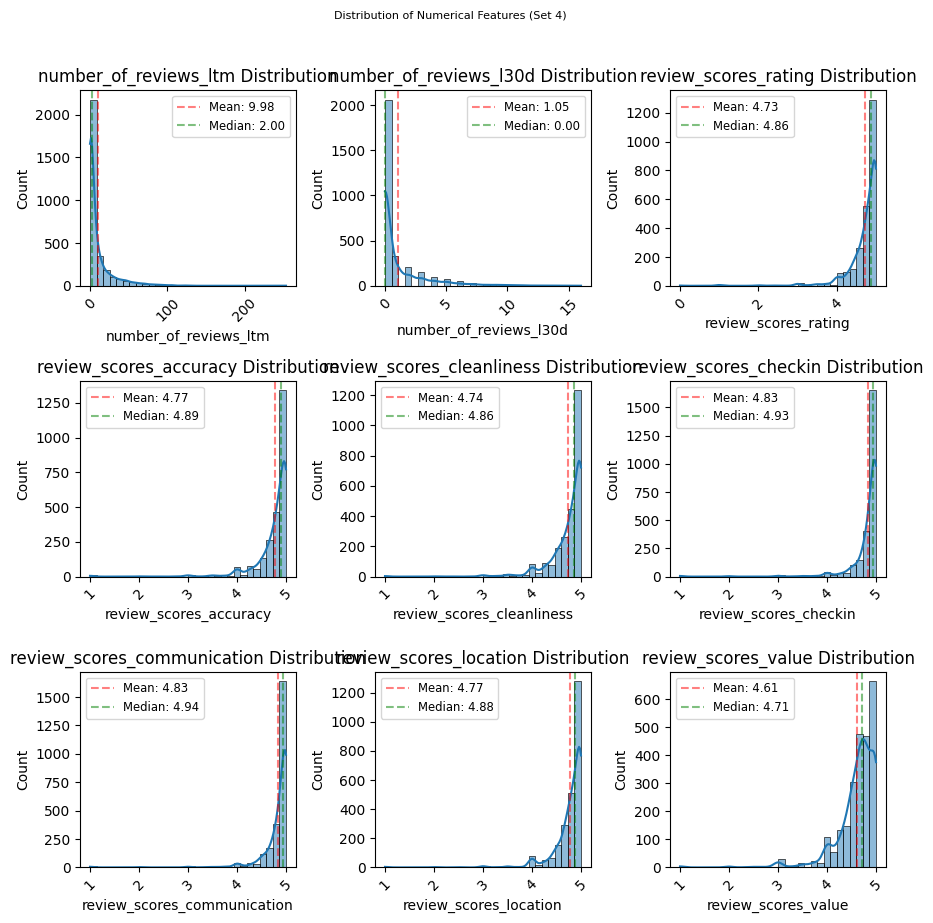

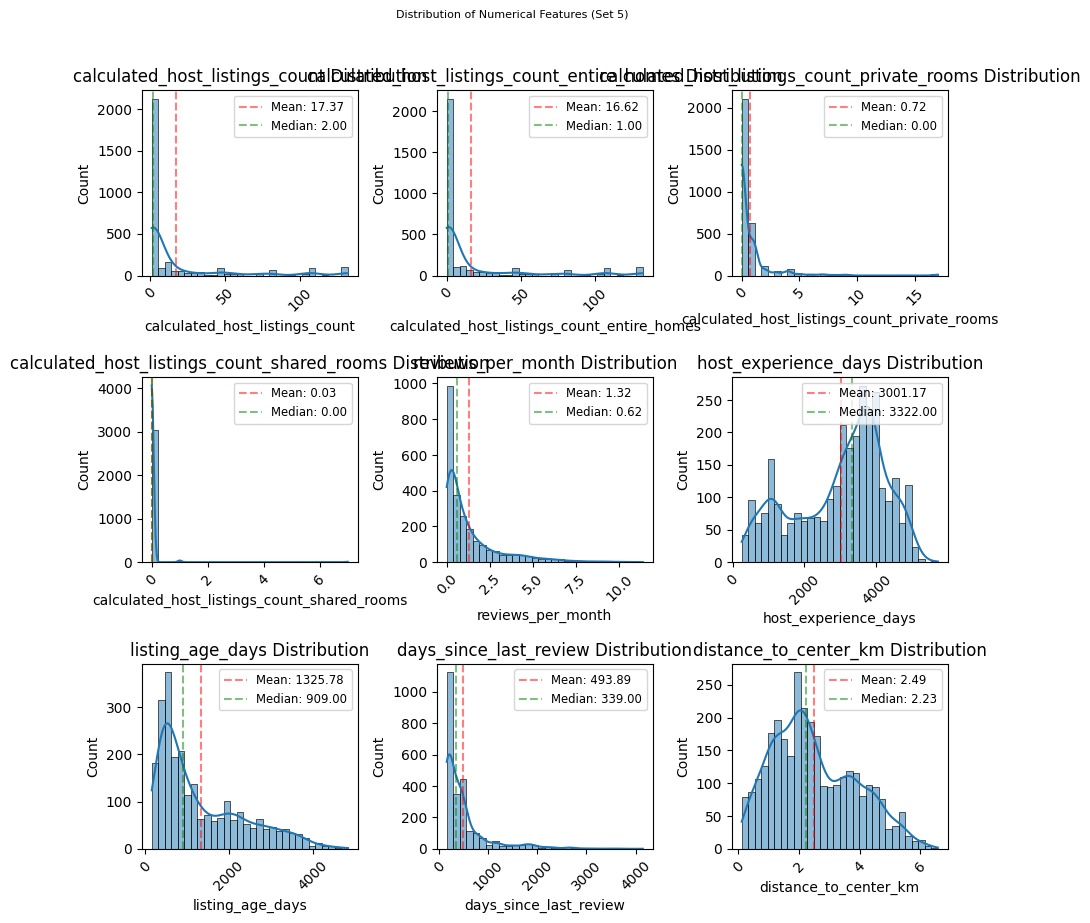

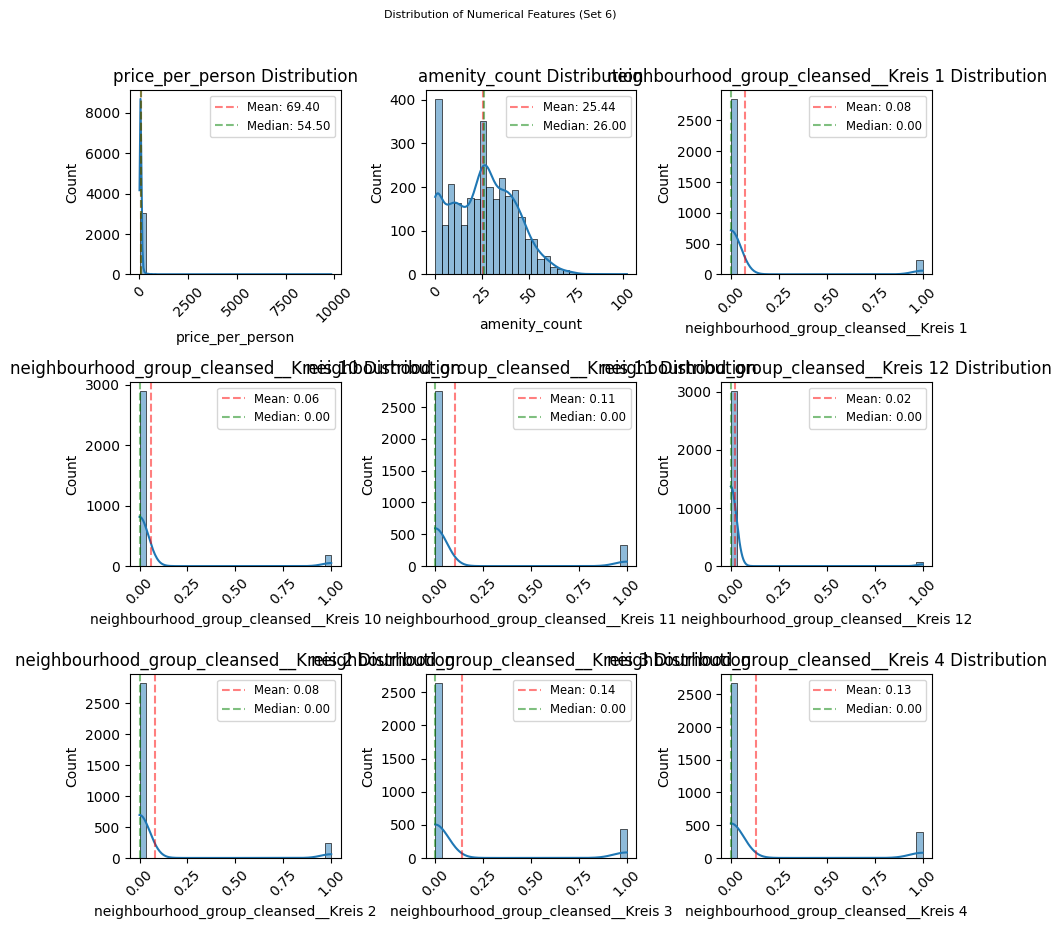

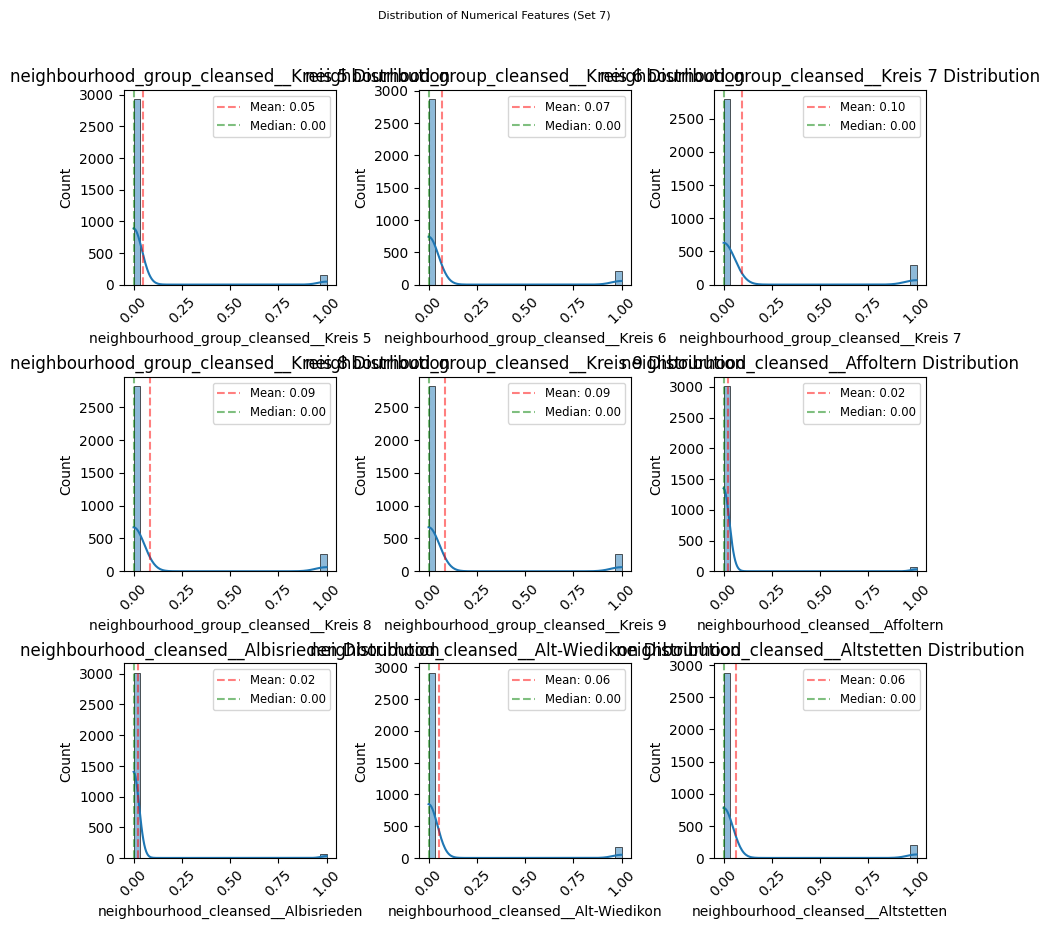

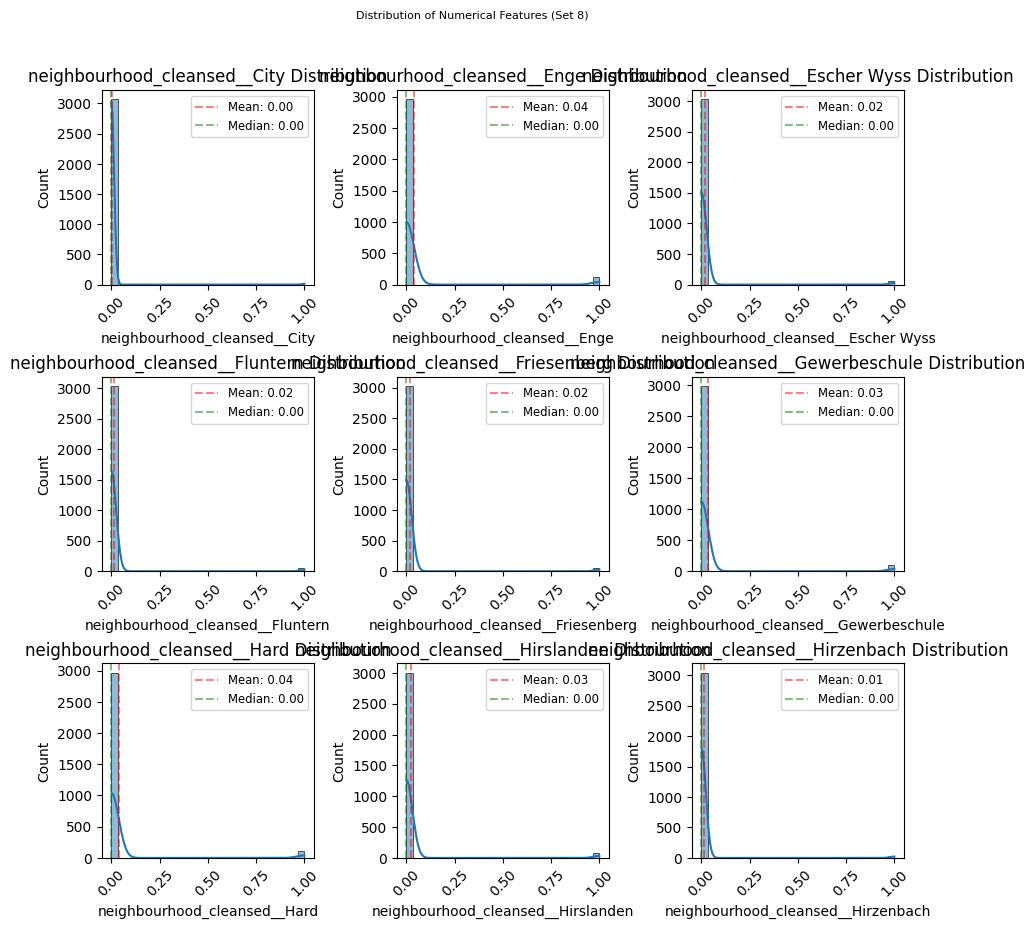

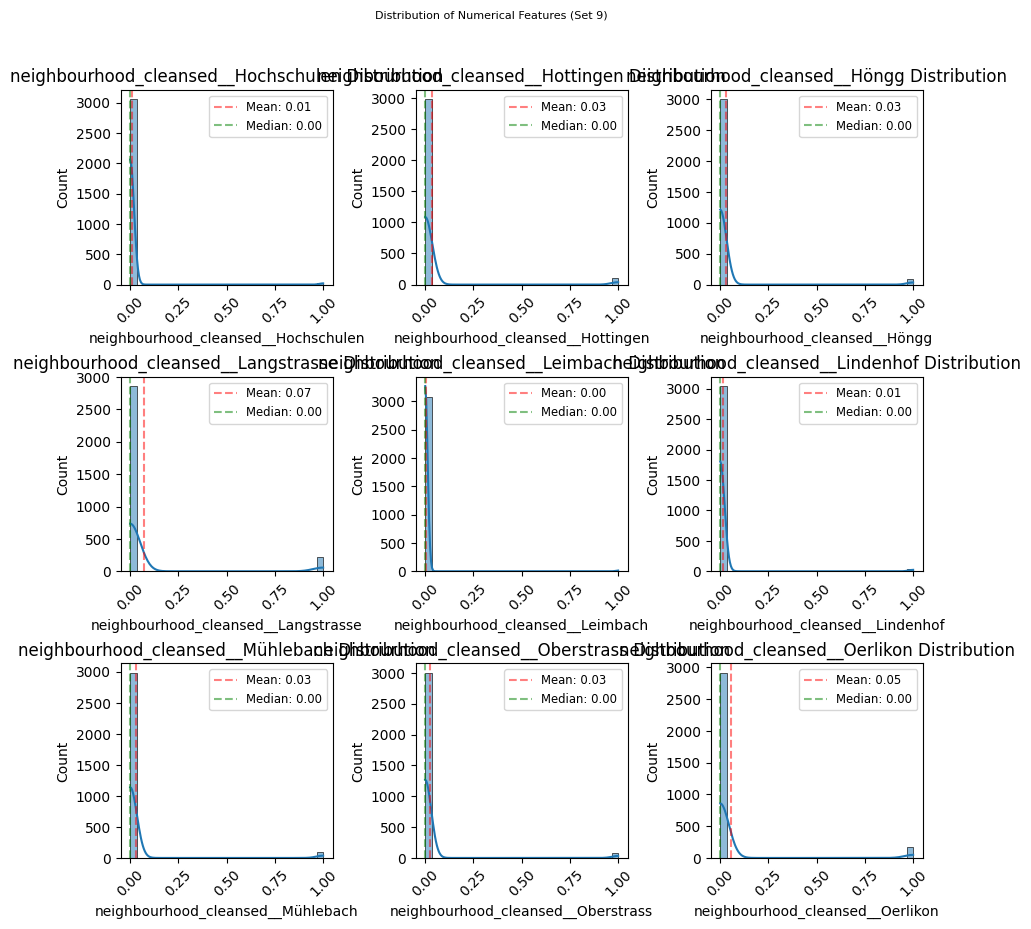

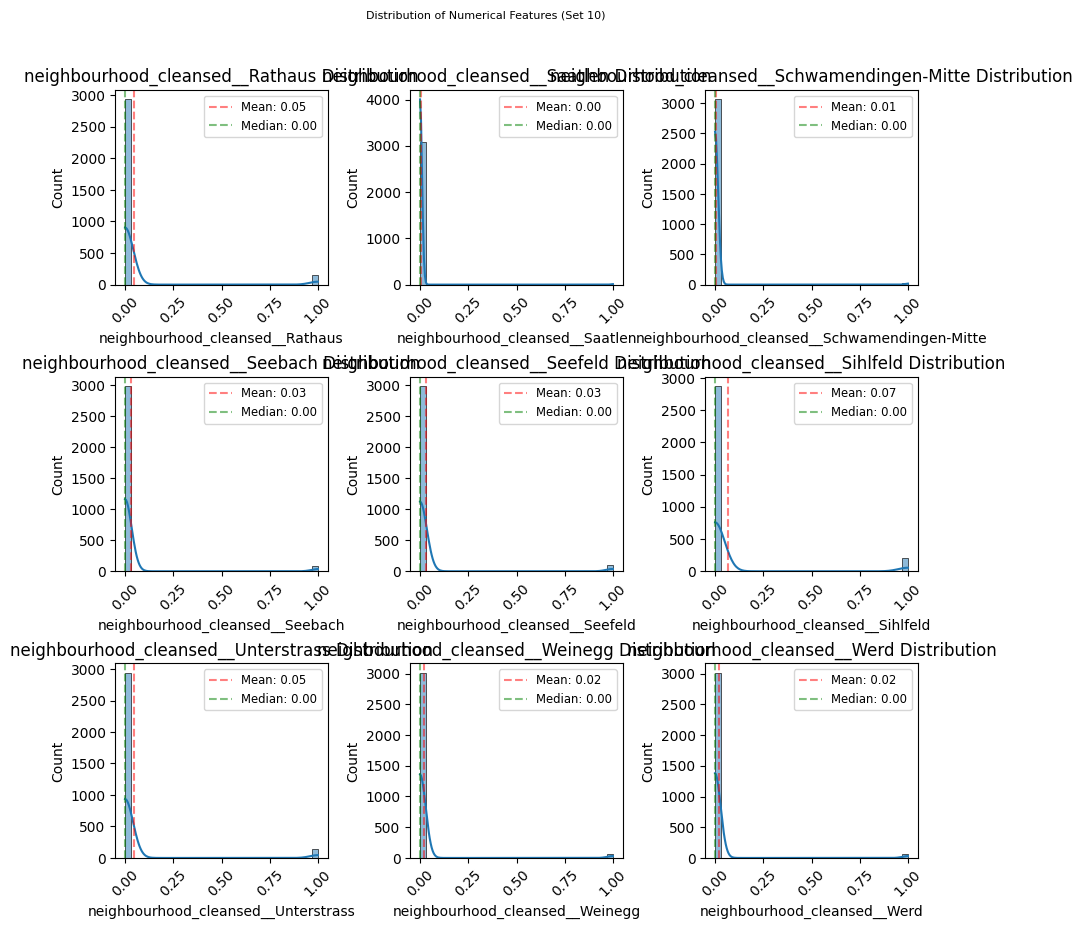

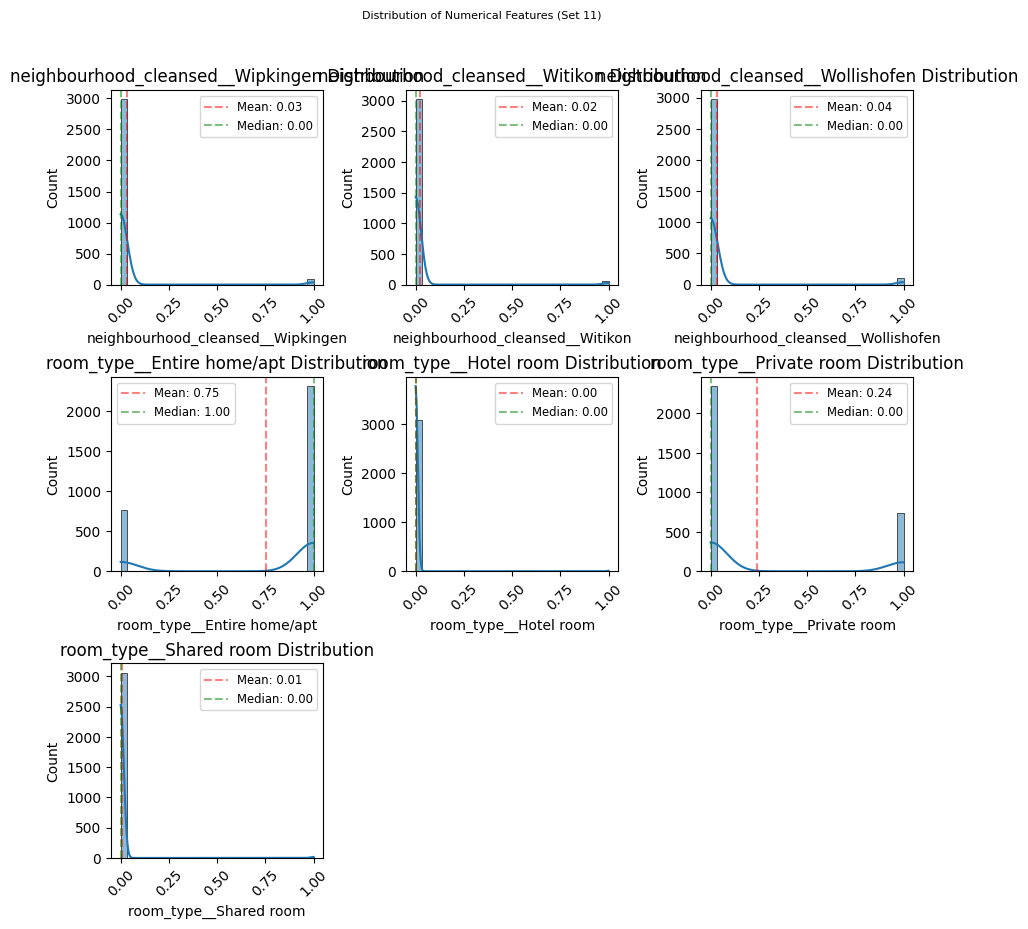

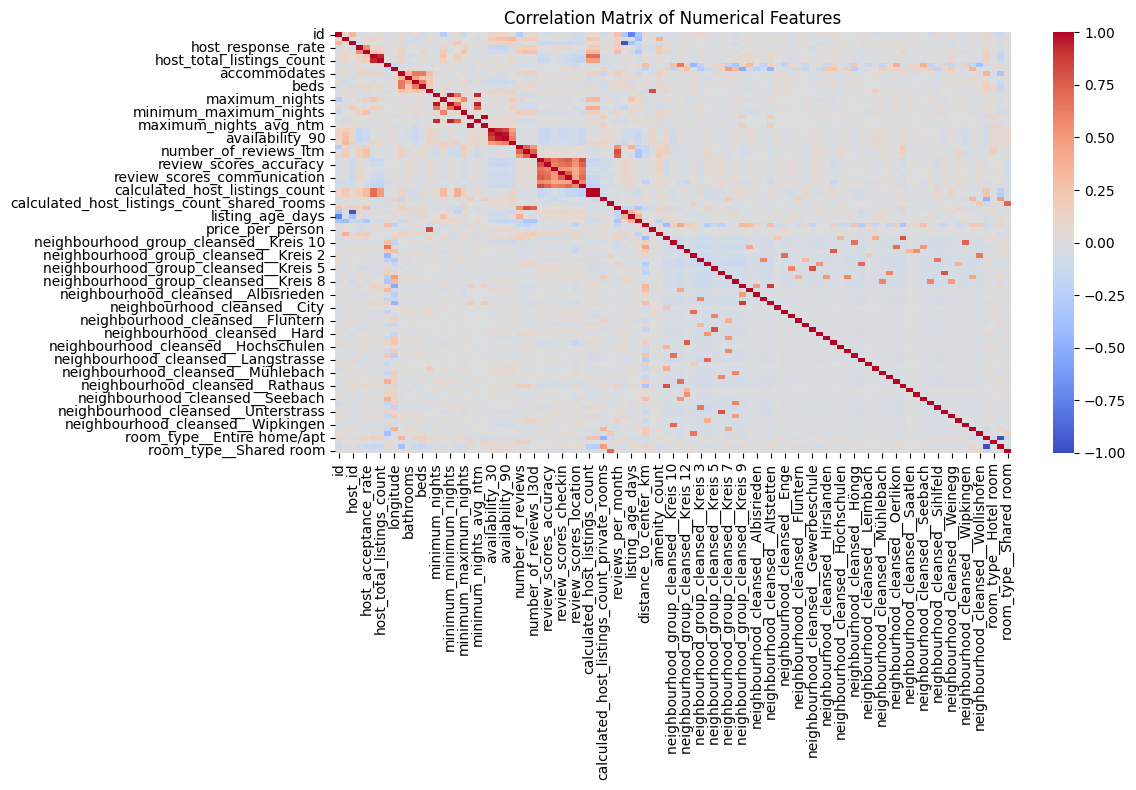

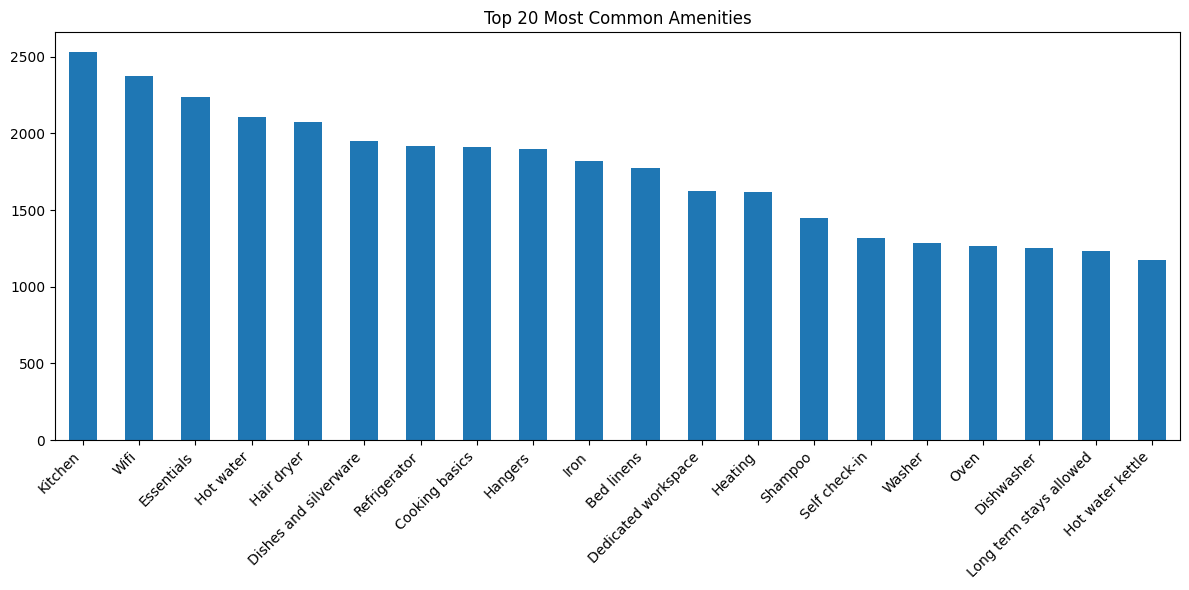

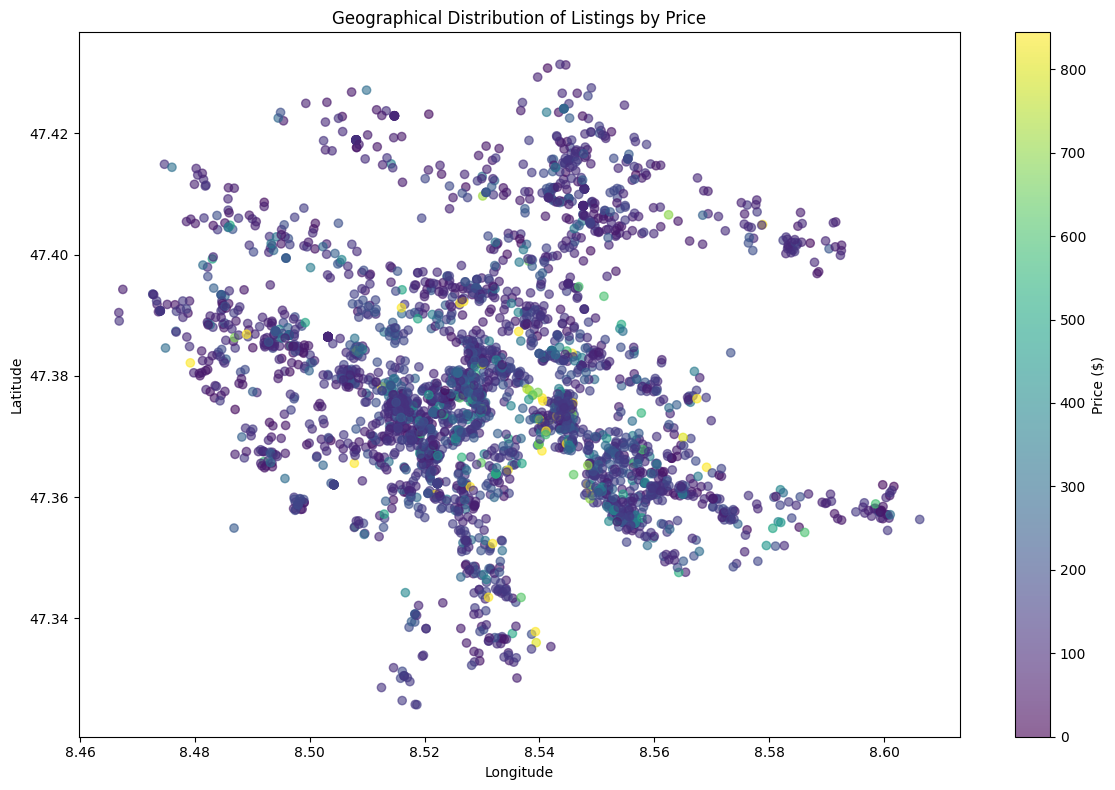

\data_quality comments:

1. missing vals
    cols with >50% missing vals:
   neighborhood_overview, host_neighbourhood, neighbourhood
    cols with 20-50% missing vals:
   host_about
    cols with <20% missing vals:
   description, host_location, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, bathrooms, bedrooms, beds, has_availability, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, reviews_per_month, listing_age_days, days_since_last_review

2. Outliers
    host_response_rate: 368 outliers (3x IQR method)
    host_listings_count: 354 outliers (3x IQR method)
    host_total_listings_count: 420 outliers (3x IQR method)
    accommodates: 9 outliers (3x IQR method)
    bathrooms: 645 outliers (3x IQR method)
    bedrooms: 805 outliers (3x IQR method)
    beds: 32 outliers (3x IQR method)
    price: 106 outli

In [12]:
analyse_numerical_features(listings_processed)
analyse_categorical_features(listings_processed)
analyse_geographical_distribution(listings_processed)

outlier_info = detect_outliers(listings_processed)
data_quality = analyse_data_quality(listings_processed, outlier_info)

print(r"\data_quality comments:")
print("=========================================")
for category, items in data_quality.items():
    print(f"\n{category}")
    if items:  # Only print items if they exist
        for item in items:
            print(f"    {item}")

In [13]:
listings_processed.filter(
    listings_processed.select_dtypes(include=["object"]).columns
).head(2)

,listing_url,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_location,host_about,...,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,neighbourhood,property_type,amenities,has_availability,calendar_last_scraped
0,https://www.airbnb.com/rooms/716444823779312887,previous scrape,Rental unit in Zürich · ★4.50 · 1 bedroom · 2 ...,Wenn du in dieser zentral gelegenen Unterkunft...,"Ruhig, Familien freundlich",https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/184862810,Saziye,"Zürich, Switzerland",NaN,...,False,https://a0.muscache.com/im/pictures/user/8f6d8...,https://a0.muscache.com/im/pictures/user/8f6d8...,NaN,"['email', 'phone']","Zürich, Switzerland",Private room in rental unit,"[Bed linens, Dining table, Hot water, Backyard...",True,2023-09-24
1,https://www.airbnb.com/rooms/717292111694830769,city scrape,Condo in Zürich · ★4.43 · 1 bedroom · 1 bed · ...,Comfortable studio right in the heart of Zuric...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/420370006,Kamila,"Zürich, Switzerland",I have been traveling all over the world using...,...,False,https://a0.muscache.com/im/pictures/user/5ae2c...,https://a0.muscache.com/im/pictures/user/5ae2c...,NaN,"['email', 'phone']",NaN,Entire condo,"[Clothing storage: closet, Lockbox, Wifi, Bed ...",True,2023-09-24


In [14]:
drop_cols = [
    "neighborhood_overview",
    "host_neighbourhood",
    "host_neighbourhood",
    "neighbourhood",
    "listing_url",
    "source",
    "picture_url",
    "host_url",
    "host_about",
    "host_name",
    "host_location",
    "calendar_last_scraped",
    "last_scraped",
    "name",
    "source",
    "host_verifications",
    "host_thumbnail_url",
    "host_picture_url",
]

In [15]:
listings_processed = listings_processed.filter(
    [col for col in listings_processed.columns if col not in drop_cols]
)

## other datasets


In [16]:
tourism_data = pd.read_csv("../local_data/tourism.csv").dropna()
noise_data = pd.read_csv("../local_data/noise_data_cleaned.csv").dropna()

## distance features


In [17]:
def calculate_noise_features(
    listings: pd.DataFrame,
    noise_data: pd.DataFrame,
    max_distance: float = 0.5,  # 500m radius
    decay_distance: float = 0.05,  # 50m half-life decay
    k: (
        int | None
    ) = 50,  # Maximum number of neighbors to consider, None for all within max_distance
) -> pd.DataFrame:
    """
    Calculate noise features for each listing based on nearby noise measurements.
    Uses exponential decay where the influence halves every decay_distance.

    Args:
        listings: DataFrame containing listings with latitude and longitude
        noise_data: DataFrame containing noise measurements with lat, lon, and noise levels
        max_distance: Maximum distance in km to consider noise sources
        decay_distance: Distance in km at which the weight becomes 0.5 (half-life)
        k: Maximum number of neighbors to consider. If None, considers all points within max_distance

    Returns:
        DataFrame with noise features added
    """
    listings = listings.copy()

    # Build KD-tree for efficient nearest neighbor search
    noise_coords = noise_data[["latitude", "longitude"]].values
    tree = cKDTree(noise_coords)

    # Query tree for each listing
    listing_coords = listings[["latitude", "longitude"]].values
    max_dist_degrees = max_distance / 111

    # Set k to either the specified value or all points
    query_k = len(noise_data) if k is None else min(k, len(noise_data))

    # Single query with the determined k
    distances, indices = tree.query(
        listing_coords, k=query_k, distance_upper_bound=max_dist_degrees, workers=-1
    )

    # Convert distances to kilometers
    distances = distances * 111

    # Create masks for valid indices and distances
    valid_mask = indices < len(noise_data)
    distance_mask = distances <= max_distance
    combined_mask = valid_mask & distance_mask

    # Initialize arrays for noise values
    day_noise = np.zeros_like(distances)
    night_noise = np.zeros_like(distances)

    # Fill in valid noise values
    day_noise[valid_mask] = noise_data["lr_day"].values[indices[valid_mask]]
    night_noise[valid_mask] = noise_data["lr_night"].values[indices[valid_mask]]

    # Calculate weights using half-life decay formula: weight = 2^(-distance/decay_distance)
    weights = np.zeros_like(distances)
    weights[combined_mask] = 2 ** (-distances[combined_mask] / decay_distance)

    # Calculate weighted sums
    listings["noise_day"] = np.sum(day_noise * weights, axis=1)
    listings["noise_night"] = np.sum(night_noise * weights, axis=1)

    # Add count of points used (optional - remove if memory is still an issue)
    listings["noise_points_within_radius"] = np.sum(combined_mask, axis=1)

    return listings


def calculate_tourism_features(
    listings: pd.DataFrame,
    tourism_data: pd.DataFrame,
    max_distance: float = 1.0,  # 1km radius
    decay_distance: float = 0.1,  # 100m half-life decay
    k: (
        int | None
    ) = 50,  # Maximum number of neighbors to consider, None for all within max_distance
) -> pd.DataFrame:
    """
    Calculate tourism features for each listing based on nearby points of interest.
    Uses exponential decay where the influence halves every decay_distance.

    Args:
        listings: DataFrame containing listings with latitude and longitude
        tourism_data: DataFrame containing tourism POIs with lat, lon, and type
        max_distance: Maximum distance in km to consider tourism points
        decay_distance: Distance in km at which the weight becomes 0.5 (half-life)
        k: Maximum number of neighbors to consider. If None, considers all points within max_distance

    Returns:
        DataFrame with tourism features added for each type
    """
    listings = listings.copy()

    # Build KD-tree for efficient nearest neighbor search
    tourism_coords = tourism_data[["latitude", "longitude"]].values
    tree = cKDTree(tourism_coords)

    # Query tree for each listing
    listing_coords = listings[["latitude", "longitude"]].values
    max_dist_degrees = max_distance / 111

    # Set k to either the specified value or all points
    query_k = len(tourism_data) if k is None else min(k, len(tourism_data))

    # Single query with the determined k
    distances, indices = tree.query(
        listing_coords, k=query_k, distance_upper_bound=max_dist_degrees, workers=-1
    )

    # Convert distances to kilometers
    distances = distances * 111

    # Create masks for valid indices and distances
    valid_mask = indices < len(tourism_data)
    distance_mask = distances <= max_distance
    combined_mask = valid_mask & distance_mask

    # Calculate weights using half-life decay formula: weight = 2^(-distance/decay_distance)
    weights = np.zeros_like(distances)
    weights[combined_mask] = 2 ** (-distances[combined_mask] / decay_distance)

    # Process each unique type of tourism point
    for poi_type in tourism_data["type"].unique():
        # Create type-specific mask
        type_indices = indices.copy()
        type_indices[~valid_mask] = 0
        type_mask = tourism_data["type"].values[type_indices] == poi_type
        type_mask = type_mask & combined_mask

        # Calculate type-specific weights and sum
        type_weights = np.zeros_like(distances)
        type_weights[type_mask] = weights[type_mask]

        # Calculate score for this type
        listings[f"tourism_{poi_type.lower().replace(' ', '_')}"] = np.sum(
            type_weights, axis=1
        )

    # Add total tourism score and count
    listings["tourism_total"] = np.sum(weights, axis=1)
    listings["tourism_points_within_radius"] = np.sum(combined_mask, axis=1)

    return listings

### test distance features


#### noise


In [18]:
try:
    print("Creating noise features...")
    listings_with_noise = calculate_noise_features(
        listings=listings_processed,
        noise_data=noise_data,
        max_distance=1,
        decay_distance=0.01,
        k=10000,
    )

    # Show new features
    noise_cols = [
        col for col in listings_with_noise.columns if col.startswith("noise_")
    ]

    print("\nNoise features:")
    print(listings_with_noise[noise_cols].describe())
    print("\nCorrelations of new features with price:")
    print(
        listings_with_noise.filter(["price"] + noise_cols)
        .corr()["price"]
        .sort_values(ascending=False)
    )


except Exception as e:
    print(f"Error occurred: {e!s}")
    print("\nDataset sizes:")
    print(f"Listings: {len(listings_processed)}")
    print(f"Noise data: {len(noise_data)}")

Creating noise features...

Noise features:
          noise_day   noise_night  noise_points_within_radius
count   3081.000000   3081.000000                 3081.000000
mean    3471.321293   2867.581588                 9996.754301
std     1934.762510   1640.388956                  180.158248
min        0.000000      0.000000                    0.000000
25%     1979.637743   1580.693865                10000.000000
50%     3379.251513   2775.617695                10000.000000
75%     5026.140419   4176.051773                10000.000000
max    11857.345132  10458.397543                10000.000000

Correlations of new features with price:
price                         1.000000
noise_night                   0.049054
noise_day                     0.047103
noise_points_within_radius   -0.004666
Name: price, dtype: float64


#### tourism


In [19]:
try:
    print("Creating tourism features...")
    listings_with_tourism = calculate_tourism_features(
        listings_processed,
        tourism_data,
        max_distance=2.0,  # 2km radius
        decay_distance=0.1,  # 100m half-life (less steep decay than noise)
        k=None,
    )

    # Show new features
    tourism_cols = [
        col for col in listings_with_tourism.columns if col.startswith("tourism_")
    ]
    print("\nTourism features:")
    print(listings_with_tourism[tourism_cols].describe())

    # Show example of high-tourism areas
    print("\nTop 5 locations by total tourism score:")
    print(
        listings_with_tourism.nlargest(5, "tourism_total")[
            ["latitude", "longitude", "tourism_total"]
            + [col for col in tourism_cols if col != "tourism_total"]
        ]
    )
    print("\nCorrelations of new features with price:")
    print(
        listings_with_tourism.filter(["price"] + tourism_cols)
        .corr()["price"]
        .sort_values(ascending=False)
    )

except Exception as e:
    print(f"Error occurred: {e!s}")
    print("\nDataset sizes:")
    print(f"Listings: {len(listings_processed)}")
    print(f"Tourism data: {len(tourism_data)}")

Creating tourism features...

Tourism features:
       tourism_barorpub  tourism_bedandbreakfast  tourism_cafeorcoffeeshop  \
count       3081.000000              3081.000000               3081.000000   
mean           0.561075                 0.001581                  0.081249   
std            1.177301                 0.031724                  0.221677   
min            0.000000                 0.000000                  0.000000   
25%            0.000000                 0.000000                  0.000000   
50%            0.006590                 0.000000                  0.000577   
75%            0.512980                 0.000000                  0.035985   
max            7.324231                 0.990684                  1.678792   

       tourism_campground  tourism_casino  tourism_church  \
count         3081.000000     3081.000000     3081.000000   
mean             0.000384        0.001893        0.036061   
std              0.010603        0.013110        0.158349   
min  

In [20]:
df_final = listings_with_tourism.join(listings_with_noise.filter(noise_cols))
df_final.to_csv("../local_data/temp_data.csv", index=False)

In [21]:
df_final.filter(df_final.select_dtypes(include=["float64", "int64"]).columns).corr()[
    "price"
].sort_values(ascending=False).head(50)

price                                    1.000000
price_per_person                         0.815684
accommodates                             0.267185
bedrooms                                 0.245353
neighbourhood_cleansed__Lindenhof        0.193621
bathrooms                                0.193408
beds                                     0.184375
tourism_restaurant                       0.158150
tourism_civicstructure                   0.154599
tourism_touristattraction                0.150076
tourism_church                           0.145072
availability_365                         0.140519
tourism_total                            0.133809
tourism_points_within_radius             0.131589
neighbourhood_group_cleansed__Kreis 1    0.127337
availability_60                          0.116817
availability_30                          0.112094
availability_90                          0.111667
tourism_museum                           0.103929
tourism_hotel                            0.102510


### missing values


### transform features


In [22]:
df_final["number_of_reviews"]

0        8
1       61
2       16
3        2
4       12
        ..
3076     3
3077     0
3078    11
3079    36
3080    20
Name: number_of_reviews, Length: 3081, dtype: int64

In [23]:
correlation_matrix = df_final.filter(
    df_final.select_dtypes(["int64", "float64"]).columns
).corr()

In [24]:
col = "accommodates"
val = 0.95

df_final[df_final[col] >= df_final[col].quantile(val)].filter(["price", col]).corr()[
    "price"
]

price           1.000000
accommodates    0.117643
Name: price, dtype: float64

In [25]:
col = "bathrooms"
val = 0.99

df_final[df_final[col] >= df_final[col].quantile(val)].filter(["price", col]).corr()[
    "price"
]

price        1.000000
bathrooms    0.254579
Name: price, dtype: float64

In [26]:
col = "beds"
val = 0.9

df_final[df_final[col] >= df_final[col].quantile(val)].filter(["price", col]).corr()[
    "price"
]

price    1.000000
beds     0.063899
Name: price, dtype: float64

In [27]:
col = "bedrooms"
val = 0.95

df_final[df_final[col] >= df_final[col].quantile(val)].filter(["price", col]).corr()[
    "price"
]

price       1.000000
bedrooms    0.169477
Name: price, dtype: float64

In [28]:
col = "noise_night"
val = 0.95

df_final[df_final[col] >= df_final[col].quantile(val)].filter(["price", col]).corr()[
    "price"
]

price          1.000000
noise_night    0.058882
Name: price, dtype: float64

In [29]:
df_final.filter(df_final.select_dtypes(["int64", "float64"]).columns)

,id,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,...,tourism_sportsactivitylocation,tourism_store,tourism_touristattraction,tourism_winery,tourism_zoo,tourism_total,tourism_points_within_radius,noise_day,noise_night,noise_points_within_radius
0,716444823779312887,20230924051608,184862810,NaN,100.0,1,1,47.422050,8.495430,3,...,0.000000,0.000000,0.000000,0.0,0.0,0.001346,2,1346.143601,1141.446823,10000
1,717292111694830769,20230924051608,420370006,100.0,99.0,30,38,47.384660,8.548380,5,...,0.000290,0.000972,0.006629,0.0,0.0,0.778902,269,1481.584709,1292.049466,10000
2,718830068578098022,20230924051608,119640383,NaN,100.0,6,7,47.364040,8.559420,1,...,0.000023,0.000777,0.000346,0.0,0.0,0.183934,130,3067.741007,2244.794269,10000
3,701607624794131304,20230924051608,408027435,NaN,NaN,1,1,47.414273,8.557140,2,...,0.001466,0.000000,0.128599,0.0,0.0,0.647469,22,5029.573554,3976.181512,10000
4,703510591302281566,20230924051608,457741826,90.0,45.0,1,1,47.373110,8.518880,2,...,0.000168,0.069799,0.000363,0.0,0.0,1.871443,181,5936.257041,5176.310479,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,935196579882766506,20240629155539,399187571,100.0,100.0,2,5,47.356359,8.558769,1,...,0.000008,0.000201,0.000043,0.0,0.0,0.536709,73,2093.109774,1484.929831,10000
3077,934064054528080186,20240629155539,541785,100.0,50.0,4,5,47.373880,8.557730,6,...,0.000089,0.000129,0.005500,0.0,0.0,0.113728,244,1884.596220,1302.638831,10000
3078,933946244971350863,20240629155539,83792836,100.0,63.0,1,1,47.373136,8.515891,4,...,0.000221,0.007812,0.002402,0.0,0.0,2.047108,142,3794.984317,3103.944482,10000
3079,932988738885937859,20240629155539,394944268,100.0,100.0,1,1,47.346834,8.526300,4,...,0.002856,0.000000,0.000004,0.0,0.0,0.235500,23,2382.613133,1978.889369,10000


In [30]:
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.max_rows", None)
print(correlation_matrix["price"].sort_values(ascending=False, key=abs))

price                                           1.000000
price_per_person                                0.815684
accommodates                                    0.267185
bedrooms                                        0.245353
neighbourhood_cleansed__Lindenhof               0.193621
bathrooms                                       0.193408
beds                                            0.184375
tourism_restaurant                              0.158150
tourism_civicstructure                          0.154599
tourism_touristattraction                       0.150076
tourism_church                                  0.145072
availability_365                                0.140519
tourism_total                                   0.133809
tourism_points_within_radius                    0.131589
neighbourhood_group_cleansed__Kreis 1           0.127337
availability_60                                 0.116817
distance_to_center_km                          -0.114466
availability_30                

In [31]:
df_features = df_final.filter(df_final.select_dtypes(["int64", "float64"]).columns)
# Berechnung von Skewness und Kurtosis für jedes Feature
from scipy.stats import skew, kurtosis

results = pd.DataFrame(
    {
        "Feature": df_features.columns,
        "Skewness": [
            (
                skew(df_features[col].dropna())
                if df_features[col].dtype in ["float64", "int64"]
                else None
            )
            for col in df_features.columns
        ],
        "Kurtosis": [
            (
                kurtosis(df_features[col].dropna())
                if df_features[col].dtype in ["float64", "int64"]
                else None
            )
            for col in df_features.columns
        ],
    }
)

# Ergebnisse anzeigen
print(results)

# Optional: Ergebnisse in eine CSV-Datei speichern
results.to_csv("skewness_kurtosis_results.csv", index=False)

                                          Feature   Skewness     Kurtosis
0                                              id   0.073402    -1.814786
1                                       scrape_id  -0.878278    -1.225241
2                                         host_id   1.077465    -0.375634
3                              host_response_rate  -3.047000     8.626764
4                            host_acceptance_rate  -1.338626     0.502761
5                             host_listings_count  14.426772   446.436264
6                       host_total_listings_count  30.176653  1334.006847
7                                        latitude   0.363839    -0.034815
8                                       longitude   0.085439     0.112457
9                                    accommodates   2.131111     8.850329
10                                      bathrooms   3.642279    26.558551
11                                       bedrooms   1.806977     7.000612
12                                    

In [32]:
# Find skewed numerical features
high_skew = results[abs(results["Skewness"]) > 0.5]
pd.set_option("display.max_rows", None)
pd.reset_option("display.max_rows")
list_high_skew = np.array(high_skew["Feature"]).tolist()
print(list_high_skew)

['scrape_id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_experience_days', 'listing_age_days', 'days_since_last_review', 'price_per_person', 'neighbourhood_group_cleansed__Kreis 1', 'neighbourhood_group_cleansed__Kreis 10', 'neigh

In [33]:
df_features.skew().abs().sort_values(ascending=False).tail(20)

listing_age_days                1.025434
scrape_id                       0.878706
availability_30                 0.763025
tourism_points_within_radius    0.620890
host_experience_days            0.551453
availability_365                0.548043
availability_60                 0.498072
distance_to_center_km           0.473759
maximum_nights                  0.441458
availability_90                 0.381102
latitude                        0.364017
noise_night                     0.243438
amenity_count                   0.206032
noise_day                       0.174914
longitude                       0.085481
id                              0.073438
minimum_maximum_nights          0.023345
tourism_place                   0.000000
tourism_landform                0.000000
tourism_winery                  0.000000
dtype: float64

In [34]:
# creating dataframe with columns that need to be transformed

df = df_final[
    [
        "host_listings_count",
        "host_total_listings_count",
        "accommodates",
        "bathrooms",
        "bedrooms",
        "beds",
        "minimum_nights",
        "minimum_minimum_nights",
        "maximum_minimum_nights",
        "maximum_maximum_nights",
        "minimum_nights_avg_ntm",
        "maximum_nights_avg_ntm",
        "availability_30",
        "availability_60",
        "number_of_reviews",
        "number_of_reviews_ltm",
        "number_of_reviews_l30d",
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
        "calculated_host_listings_count",
        "calculated_host_listings_count_entire_homes",
        "calculated_host_listings_count_private_rooms",
        "calculated_host_listings_count_shared_rooms",
        "reviews_per_month",
        "host_experience_days",
        "listing_age_days",
        "days_since_last_review",
        "price_per_person",
        "tourism_barorpub",
        "tourism_bedandbreakfast",
        "tourism_cafeorcoffeeshop",
        "tourism_campground",
        "tourism_casino",
        "tourism_church",
        "tourism_civicstructure",
        "tourism_dayspa",
        "tourism_entertainmentbusiness",
        "tourism_hostel",
        "tourism_hotel",
        "tourism_localbusiness",
        "tourism_lodgingbusiness",
        "tourism_movietheater",
        "tourism_museum",
        "tourism_musicvenue",
        "tourism_nightclub",
        "tourism_park",
        "tourism_performingartstheater",
        "tourism_publicswimmingpool",
        "tourism_restaurant",
        "tourism_shoppingcenter",
        "tourism_sportsactivitylocation",
        "tourism_store",
        "tourism_touristattraction",
        "tourism_zoo",
        "tourism_total",
        "tourism_points_within_radius",
        "noise_points_within_radius",
    ]
]

In [35]:
df

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,maximum_maximum_nights,...,tourism_publicswimmingpool,tourism_restaurant,tourism_shoppingcenter,tourism_sportsactivitylocation,tourism_store,tourism_touristattraction,tourism_zoo,tourism_total,tourism_points_within_radius,noise_points_within_radius
0,1,1,3,1.0,NaN,2.0,1,1,1,1125,...,0.000938,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001346,2,10000
1,30,38,5,1.0,1.0,1.0,1,1,1,365,...,0.000057,0.042409,0.000005,0.000290,0.000972,0.006629,0.0,0.778902,269,10000
2,6,7,1,1.5,NaN,1.0,2,2,2,1125,...,0.000151,0.090448,0.000000,0.000023,0.000777,0.000346,0.0,0.183934,130,10000
3,1,1,2,1.5,NaN,1.0,3,3,3,1125,...,0.000000,0.201906,0.000000,0.001466,0.000000,0.128599,0.0,0.647469,22,10000
4,1,1,2,1.0,NaN,1.0,1,1,1,14,...,0.000057,0.642579,0.000015,0.000168,0.069799,0.000363,0.0,1.871443,181,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,2,5,1,1.0,0.0,1.0,20,3,20,365,...,0.026653,0.091735,0.000000,0.000008,0.000201,0.000043,0.0,0.536709,73,10000
3077,4,5,6,2.0,3.0,4.0,5,5,5,365,...,0.000007,0.035006,0.000000,0.000089,0.000129,0.005500,0.0,0.113728,244,10000
3078,1,1,4,1.0,1.0,1.0,3,3,3,90,...,0.000153,0.588679,0.000004,0.000221,0.007812,0.002402,0.0,2.047108,142,10000
3079,1,1,4,1.0,2.0,2.0,1,1,4,1125,...,0.000148,0.000153,0.000000,0.002856,0.000000,0.000004,0.0,0.235500,23,10000


In [36]:
list_no_high_skew = [
    ele for ele in df_features.columns.tolist() if ele not in list_high_skew
]

In [39]:
# transformation
from sklearn.preprocessing import PowerTransformer, StandardScaler

power_scaler = PowerTransformer(method="yeo-johnson")
standard_scaler = StandardScaler()

list_no_high_skew = [
    ele for ele in df_features.columns.tolist() if ele not in list_high_skew
]
df_final.loc[:, list_high_skew] = power_scaler.fit_transform(
    df_final.loc[:, list_high_skew]
)
df_final.loc[:, list_no_high_skew] = standard_scaler.fit_transform(
    df_final.loc[:, list_no_high_skew]
)


print("DataFrame after Yeo-Johnson transformation")
df_final.to_csv("../local_data/df_final_scaled.csv", index=False)
df_final

DataFrame after Yeo-Johnson transformation


,id,scrape_id,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,tourism_sportsactivitylocation,tourism_store,tourism_touristattraction,tourism_winery,tourism_zoo,tourism_total,tourism_points_within_radius,noise_day,noise_night,noise_points_within_radius
0,0.584915,-1.533262,Wenn du in dieser zentral gelegenen Unterkunft...,0.741349,2018-04-17,NaN,NaN,0.972546,False,-1.024634,...,-0.907846,-0.790355,-0.790654,0.0,-0.461888,-1.362325,-1.773603,-1.098596,-1.052442,0.018019
1,0.586808,-1.533262,Comfortable studio right in the heart of Zuric...,1.335869,2021-08-27,within an hour,0.634417,0.859136,False,1.231069,...,-0.815258,-0.591889,0.075437,0.0,-0.461888,0.117744,0.942941,-1.028581,-0.960618,0.018019
2,0.590243,-1.533262,"Near the center of Zurich, you'll have a priva...",0.452512,2017-03-07,NaN,NaN,0.972546,False,0.698477,...,-0.900267,-0.630216,-0.735380,0.0,-0.461888,-0.815905,0.189018,-0.208628,-0.379720,0.018019
3,0.551771,-1.533262,Von dieser Unterkunft aus seid ihr in Nullkom...,1.313125,2021-06-19,NaN,NaN,NaN,False,-1.024634,...,-0.474939,-0.790355,1.721227,0.0,-0.461888,-0.022483,-0.996212,0.805528,0.675925,0.018019
4,0.556022,-1.533262,Meine 3 1/2-Zimmer-Wohnung ist ein komfortable...,1.401380,2022-05-06,within a day,-1.594666,-1.343946,False,-1.024634,...,-0.853550,1.540618,-0.732713,0.0,-0.461888,0.744997,0.507984,1.274232,1.407656,0.018019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,1.073576,0.682812,enjoy a lovely attic just for your self!<br />...,1.296466,2021-04-29,within an hour,0.634417,0.972546,False,-0.169530,...,-0.905199,-0.747700,-0.783691,0.0,-0.461888,-0.162713,-0.280656,-0.712457,-0.843017,0.018019
3077,1.071046,0.682812,"3 bedroom appartment with garden, 2 bathrooms ...",-2.006505,2011-04-28,within a few hours,0.634417,-1.283123,False,0.451376,...,-0.879021,-0.762892,-0.046002,0.0,-0.461888,-1.002478,0.830194,-0.820247,-0.954162,0.018019
3078,1.070783,0.682812,"Cosy, modern two-room apartment in a round tow...",0.228749,2016-07-14,within a few hours,0.634417,-1.071811,True,-1.024634,...,-0.836729,0.381250,-0.431647,0.0,-0.461888,0.802039,0.270369,0.167315,0.144113,0.018019
3079,1.068644,0.682812,Welcome to our renovated apartment building in...,1.288356,2021-03-31,within an hour,0.634417,0.972546,True,-1.024634,...,-0.139211,-0.790355,-0.789969,0.0,-0.461888,-0.693894,-0.974518,-0.562800,-0.541845,0.018019
